In [1]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm
import matplotlib.pyplot as plt

def train_krr(X, y, pars=None):
    """
    训练核岭回归模型，并使用网格搜索进行超参数优化。
    """
    if pars is None:
        pars = {}
    if 'lambda' not in pars:
        pars['lambda'] = None
    if 'sigma' not in pars:
        pars['sigma'] = 1
    if 'sigmas.CV' not in pars:
        pars['sigmas.CV'] = None
    if 'lambdas.CV' not in pars:
        pars['lambdas.CV'] = np.logspace(-6, 4, 11)
    
    if X is None or X.shape[1] == 0:
        result = {
            'residuals': y - np.mean(y),
            'model': None,
        }
        return result
    
    # 设置用于网格搜索的参数网格
    param_grid = {}
    if pars['lambda'] is None:
        param_grid['alpha'] = pars['lambdas.CV']
    else:
        param_grid['alpha'] = [pars['lambda']]

    if pars['sigma'] is None:
        param_grid['gamma'] = pars['sigmas.CV']
    else:
        param_grid['gamma'] = [pars['sigma']]
    
    # 定义核岭回归模型
    krr = KernelRidge(kernel='rbf')
    
    # 使用网格搜索进行超参数优化
    grid_search = GridSearchCV(krr, param_grid, cv=10, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)
    
    # 使用最佳参数训练模型
    best_krr = grid_search.best_estimator_
    
    # 进行预测
    residuals = y - best_krr.predict(X)
    
    result = {
        'model': best_krr,
        'residuals': residuals
    }
    
    return result


def comp_resids(V, Z, regr_pars, regr_method):
    V = np.asarray(V).astype(float).flatten()
    if regr_method == "kernel.ridge":
        mod_VonZ = train_krr(Z, V, regr_pars)
        
    else:
        raise ValueError(f"Unsupported regression method: {regr_method}")
    return mod_VonZ['residuals']

In [2]:
def gcm_test(X=None, Y=None, Z=None, alpha=0.05, regr_method="kernel.ridge", regr_pars=None, plot_residuals=False, nsim=499, resid_XonZ=None, resid_YonZ=None):
    if regr_pars is None:
        regr_pars = {}
    
    if Z is None:
        if resid_XonZ is None:
            resid_XonZ = X
        if resid_YonZ is None:
            resid_YonZ = Y
    else:
        resid_func = lambda V: comp_resids(V, Z, regr_pars, regr_method)
        if resid_XonZ is None:
            if X is None:
                raise ValueError("Either X or resid_XonZ must be provided.")
            resid_XonZ = np.apply_along_axis(resid_func, 0, X)
        if resid_YonZ is None:
            if Y is None:
                raise ValueError("Either Y or resid_YonZ must be provided.")
            resid_YonZ = np.apply_along_axis(resid_func, 0, Y)
            
    # 多元变量情况：
    if resid_XonZ.shape[1] > 1 or resid_YonZ.shape[1] > 1:
        d_X = resid_XonZ.shape[1]
        d_Y = resid_YonZ.shape[1]
        nn = resid_XonZ.shape[0]
        
        # 我的初始方法：手动计算 T_{jk}
        T_matrix = np.zeros((d_X, d_Y))
        for j in range(d_X):
            for k in range(d_Y):
                X_j_resid = resid_XonZ[:, j]
                Y_k_resid = resid_YonZ[:, k]
                R_jk = X_j_resid * Y_k_resid
                R_jk_mean = np.mean(R_jk)
                R_jk_var = np.var(R_jk, ddof=1)
                T_matrix[j, k] = R_jk_mean / np.sqrt(R_jk_var)

        # 论文作者R代码中的方法，用矩阵的形式表示：
        order = np.repeat(np.arange(d_Y), d_X)
        resid_YonZ_repeated_r = resid_YonZ[:, order]
        resid_XonZ_repeated_r = np.repeat(resid_XonZ, d_Y, axis=1)
        # 逐元素相乘并转置
        R_mat = (resid_XonZ_repeated_r * resid_YonZ_repeated_r).reshape(nn, d_X * d_Y).T
        # 归一化
        R_mat = R_mat / np.sqrt(np.var(R_mat, axis=1, ddof=1, keepdims=True))
        
        # 两种方法计算结果相同
        test_statistic1 = np.max(np.abs(np.mean(R_mat, axis=1))) * np.sqrt(nn)
        test_statistic2 = np.max(T_matrix) * np.sqrt(nn)
        print("Test statistic1:", test_statistic1)
        print("Test statistic2:", test_statistic2)
        test_statistic = test_statistic2
        
        # 模拟检验统计量的分布
        test_statistic_sim = np.apply_along_axis(lambda x: np.max(np.abs(np.dot(R_mat, x))), 0, np.random.randn(nn, nsim)) / np.sqrt(nn)
        
        p_value = (np.sum(test_statistic_sim >= test_statistic) + 1) / (nsim + 1)
        
        print("Test statistic:", test_statistic)
        print("P-value:", p_value)
        if plot_residuals:
            fig, axes = plt.subplots(resid_XonZ.shape[1], resid_YonZ.shape[1], figsize=(15, 15))
            for i in range(resid_XonZ.shape[1]):
                for j in range(resid_YonZ.shape[1]):
                    ax = axes[i, j] if resid_XonZ.shape[1] > 1 and resid_YonZ.shape[1] > 1 else axes
                    ax.scatter(resid_XonZ[:, i], resid_YonZ[:, j])
                    ax.set_title(f'Scatter plot of residuals {i} vs {j}')
            plt.tight_layout()
            plt.show()
    else:
        nn = resid_XonZ.shape[0]
        R = resid_XonZ.flatten() * resid_YonZ.flatten()
        R_sq = R ** 2
        mean_R = np.mean(R)
        test_statistic = np.sqrt(nn) * mean_R / np.sqrt(np.mean(R_sq) - mean_R ** 2)
        p_value = 2 * norm.sf(np.abs(test_statistic))
        
        if plot_residuals:
            plt.scatter(resid_XonZ, resid_YonZ)
            plt.title('Scatter plot of residuals')
            plt.show()
    
    return {
        'p_value': p_value,
        'test_statistic': test_statistic,
        'reject': p_value < alpha
    }

X: (500, 1) Y: (500, 1) Y2: (500, 1)


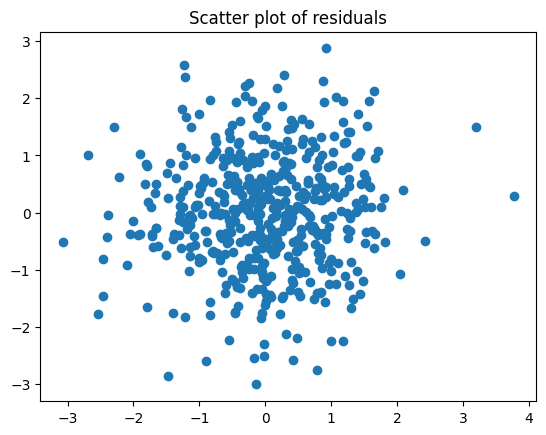

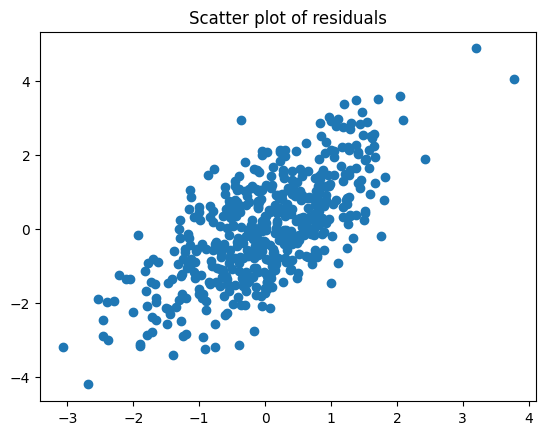

Test 1 - p_value: 0.2575012977363399 reject: False
Test 2 - p_value: 3.81699769902611e-30 reject: True


In [3]:
# 生成一维示例数据
np.random.seed(1)
n = 500
Z = 4 * np.random.randn(n, 1)
X = 2 * np.sin(Z) + np.random.randn(n, 1)
Y = 2 * np.sin(Z) + np.random.randn(n, 1)
Y2 = 2 * np.sin(Z) + X + np.random.randn(n, 1)
print("X:",X.shape,"Y:",Y.shape,"Y2:",Y2.shape)

result1 = gcm_test(X, Y, Z, regr_method="kernel.ridge", plot_residuals=True)
result2 = gcm_test(X, Y2, Z, regr_method="kernel.ridge", plot_residuals=True)

print("Test 1 - p_value:", result1['p_value'], "reject:", result1['reject'])
print("Test 2 - p_value:", result2['p_value'], "reject:", result2['reject'])

X: (500, 3) Y: (500, 2) Y2: (500, 2)
Test statistic1: 1.588073219999579
Test statistic2: 1.5880732199995786
Test statistic: 1.5880732199995786
P-value: 0.4


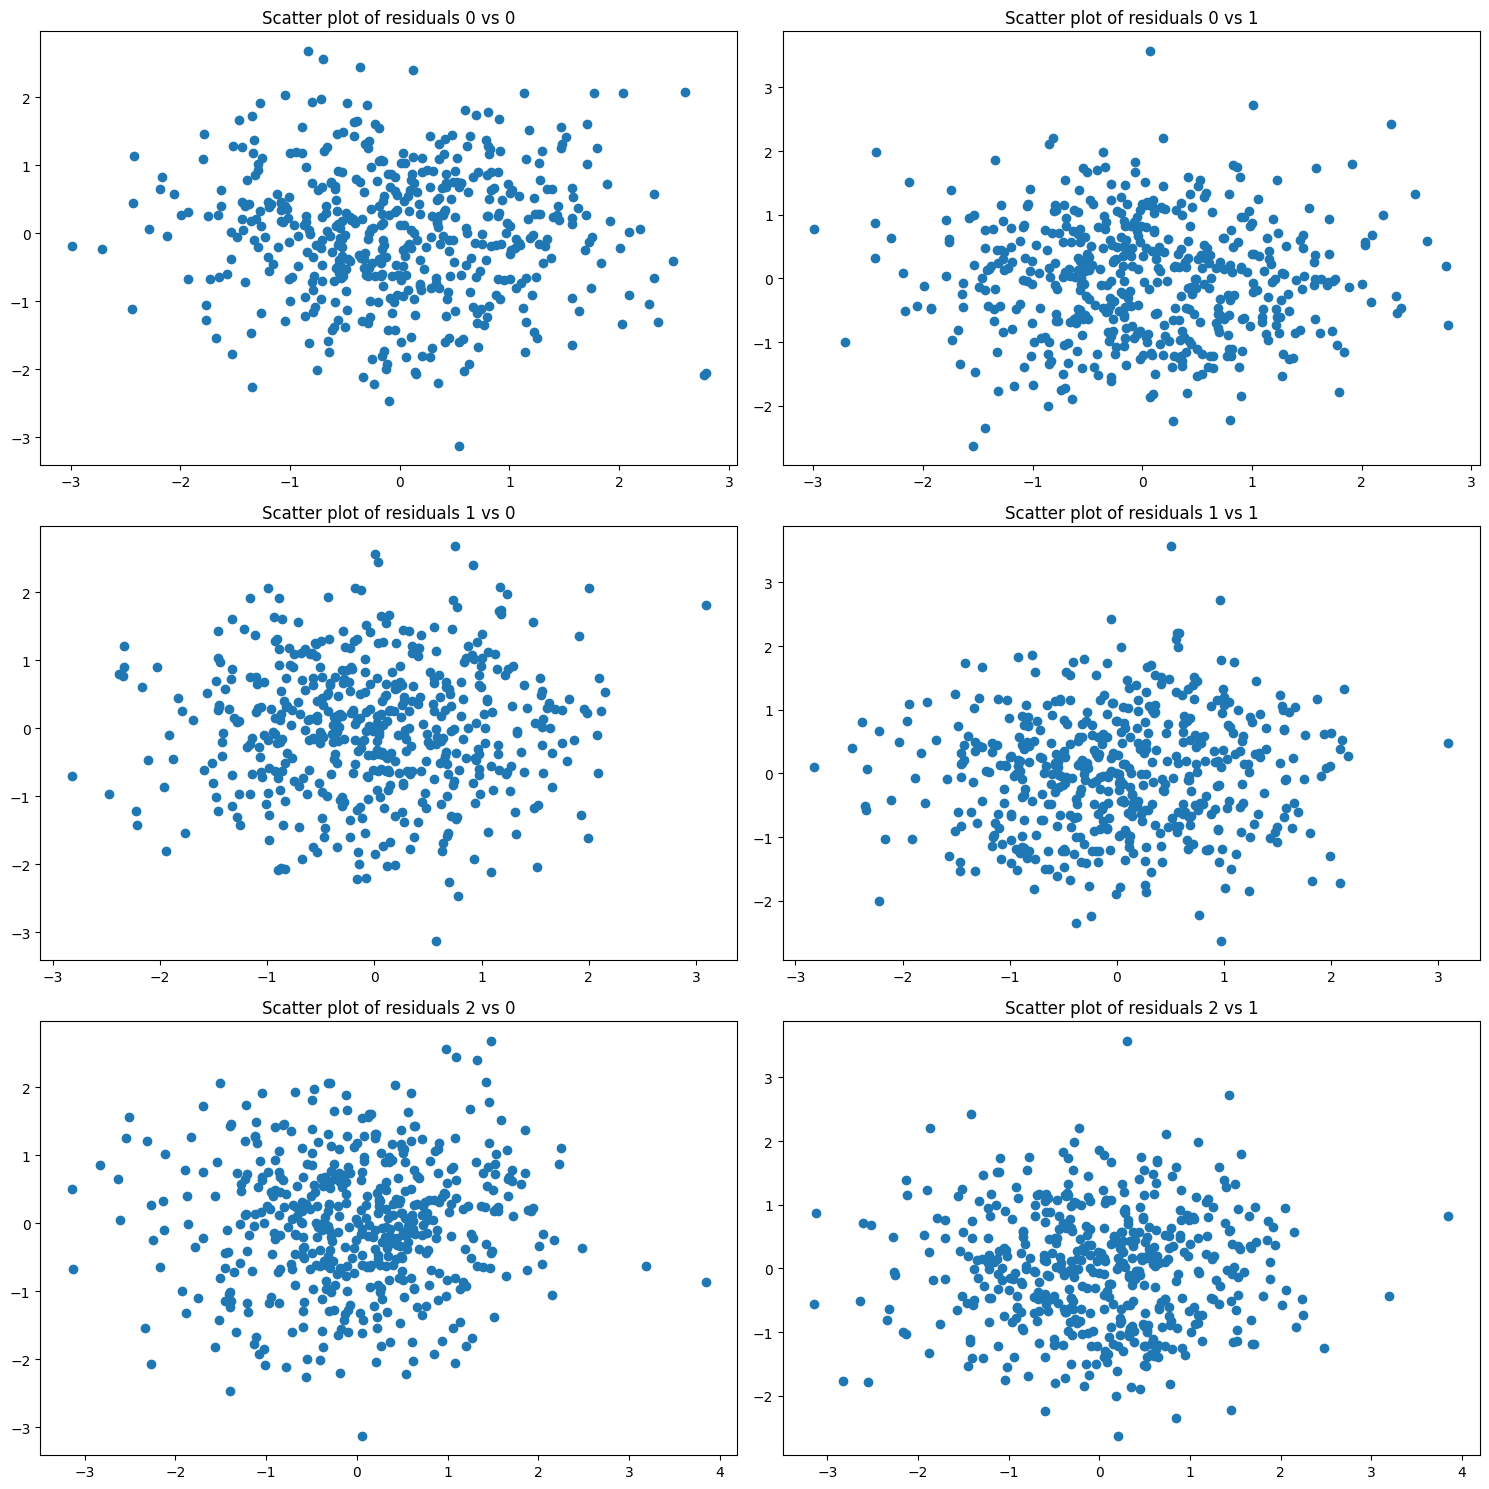

Test statistic1: 13.823757175891062
Test statistic2: 13.823757175891057
Test statistic: 13.823757175891057
P-value: 0.002


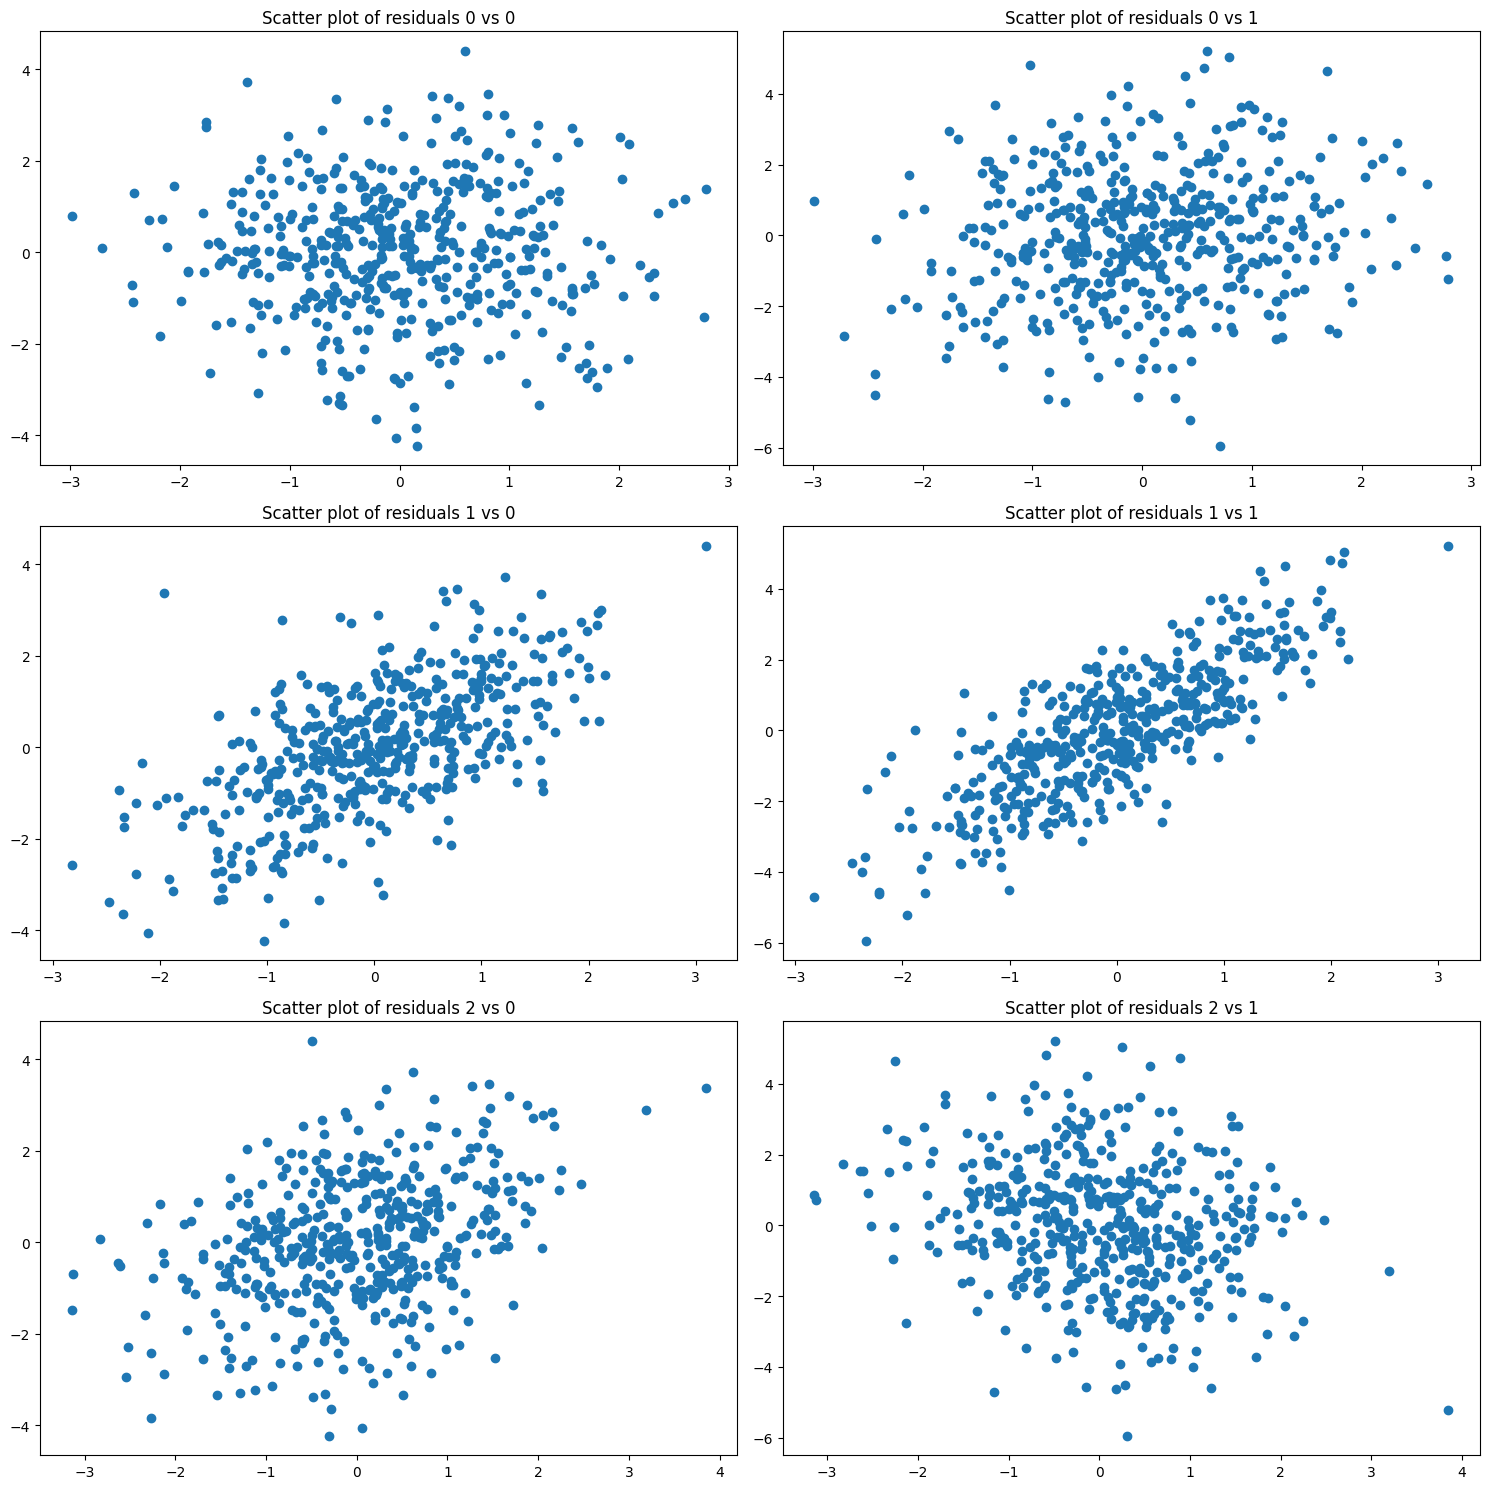

Test 1 - p_value: 0.4 reject: False
Test 2 - p_value: 0.002 reject: True


In [4]:
# 生成多元示例数据
np.random.seed(1)
n = 500
d_X = 3
d_Y = 2

Z = 4 * np.random.randn(n, 1)
X = 2 * np.sin(Z) + np.random.randn(n, d_X)
Y = 2 * np.sin(Z) + np.random.randn(n, d_Y)
Y2 = 2 * np.sin(Z) + np.dot(X, np.random.randn(d_X, d_Y)) + np.random.randn(n, d_Y)

print("X:", X.shape, "Y:", Y.shape, "Y2:", Y2.shape)

result1 = gcm_test(X, Y, Z, regr_method="kernel.ridge", plot_residuals=True)
result2 = gcm_test(X, Y2, Z, regr_method="kernel.ridge", plot_residuals=True)

print("Test 1 - p_value:", result1['p_value'], "reject:", result1['reject'])
print("Test 2 - p_value:", result2['p_value'], "reject:", result2['reject'])